#### Wizualizacja danych z użyciem t-SNE

In [1]:
import sklearn.datasets as skd

cover_data = skd.fetch_covtype(
    data_home='../../data/cover_dataset/',
    download_if_missing=False,
    random_state=23,
    shuffle=False,
    return_X_y=False
)

print(cover_data['data'].shape)
print(cover_data['target'].shape)

(581012, 54)
(581012,)


In [2]:
import sklearn.manifold as skm
import numpy as np
import random

random_indices = np.array(random.sample(range(len(cover_data['data'])), 100))
model = skm.TSNE(learning_rate=100)
data_features = cover_data['data'][random_indices]
transformed = model.fit_transform(data_features)

x = transformed[:,0]
y = transformed[:,1]
images_array = cover_data['data'][random_indices]

print(data_features.shape)
print(data_features.shape)
print(x.shape)
print(y.shape)
print(images_array.shape)

(100, 54)
(100, 54)
(100,)
(100,)
(100, 54)


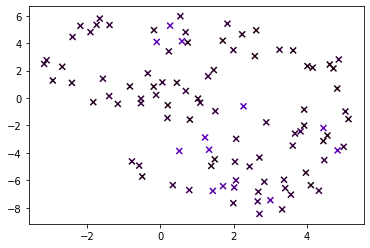

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
axes = fig.add_subplot(111)
cmap = plt.get_cmap('gnuplot')
columns = data_features.shape[1]
colors = [cmap(i/columns) for i in cover_data['target'][random_indices]]
line = axes.scatter(x, y, marker='x', color=colors)

plt.show()

#### Implementacja klasyfikatora kNN

In [4]:
import sklearn.model_selection as sks

training_set, test_set, training_labels, test_labels = sks.train_test_split(cover_data['data'], cover_data['target'], test_size=0.33, random_state=3)

print(training_set.shape)
print(training_labels.shape)
print(test_set.shape)
print(test_labels.shape)

(389278, 54)
(389278,)
(191734, 54)
(191734,)


In [8]:
def knn_classifier(i : int, k : int) -> int:
    tile = np.tile(test_set[i], (np.shape(training_set)[0], 1))
    distances = np.sum((tile - training_set) ** 2, axis=1)
    sorted_indices = np.argsort(distances)[0:k]
    nearest_neighbors = np.array(training_labels)[sorted_indices]
    return max(nearest_neighbors)


k = 3
sample_i = 444
neighbor = knn_classifier(sample_i, k)
print(neighbor)

2


In [29]:
slice_v = 20_000
test_set_slice = test_set[0:slice_v]
test_labels_slice = test_labels[0:slice_v]
training_set_slice = training_set[0:slice_v]
training_labels_slice = training_labels[0:slice_v]

In [30]:
import time as tm

def print_dots(j : int, mod : int):
    if j % mod == 0:
        print('.', end='')


def knn_classifier_all(k : int) -> np.array:
    results = []

    for i in range(len(test_set_slice)):
        tile = np.tile(test_set_slice[i], (np.shape(training_set_slice)[0], 1))
        distances = np.sum((tile - training_set_slice) ** 2, axis=1)
        sorted_indices = np.argsort(distances)[0:k]
        nearest_neighbors = np.array(training_labels_slice)[sorted_indices]
        results.append(max(nearest_neighbors))
        print_dots(i, 1000)

    return np.array(results)


start_pred_1 = tm.time()
prediction_1 = knn_classifier_all(k)
elapsed_pred_1 = tm.time() - start_pred_1
print()
print(prediction_1[0:20])
print(test_labels[0:20])

....................
[1 1 2 2 1 1 6 1 1 2 1 2 2 2 2 2 1 2 2 7]
[1 1 2 2 1 1 3 1 1 1 1 2 2 2 2 2 1 2 2 7]


In [31]:
import sklearn.neighbors as skn

start_pred_2 = tm.time()
skn_classifier = skn.KNeighborsClassifier(n_neighbors=k)
skn_classifier.fit(training_set_slice, training_labels_slice)
prediction_2 = skn_classifier.predict(test_set_slice)
elapsed_pred_2 = tm.time() - start_pred_2
print(prediction_2[0:20])
print(test_labels[0:20])

[1 1 2 2 1 1 3 1 1 2 1 2 2 1 2 2 1 2 1 7]
[1 1 2 2 1 1 3 1 1 1 1 2 2 2 2 2 1 2 2 7]


#### Porównanie wyników klasyfikacji kNN

In [32]:
import sys as sy

print(elapsed_pred_1)
print(sy.getsizeof(prediction_1))
print()
print(elapsed_pred_2)
print(sy.getsizeof(skn_classifier) + sy.getsizeof(prediction_2))

146.99129724502563
80096

1.6426820755004883
160


In [33]:
import sklearn.metrics as skt

accuracy_1 = skt.accuracy_score(test_labels_slice, prediction_1)
accuracy_2 = skt.accuracy_score(test_labels_slice, prediction_2)
print(accuracy_1 * 100, '%')
print(accuracy_2 * 100, '%')

76.25 %
82.1 %


In [34]:
import pandas as pd

actual_series = pd.Series(test_labels_slice, name='actual')
predicted_series_1 = pd.Series(prediction_1, name='predicted')
confusion_matrix_1 = pd.crosstab(actual_series, predicted_series_1)
confusion_matrix_1

predicted,1,2,3,4,5,6,7
actual,,,,,,,
1,4203,2624,7,0,72,5,277
2,252,8752,273,1,333,193,40
3,0,38,856,48,16,311,0
4,0,0,11,67,0,27,0
5,4,57,6,0,245,8,1
6,0,24,67,5,3,525,0
7,33,14,0,0,0,0,602


In [35]:
predicted_series_2 = pd.Series(prediction_2, name='predicted')
confusion_matrix_2 = pd.crosstab(actual_series, predicted_series_2)
confusion_matrix_2

predicted,1,2,3,4,5,6,7
actual,,,,,,,
1,5895,1211,1,0,9,0,72
2,1158,8479,98,0,65,40,4
3,6,156,992,15,1,99,0
4,0,2,43,53,0,7,0
5,34,141,8,0,136,2,0
6,10,107,136,5,3,363,0
7,127,20,0,0,0,0,502


Wersja sklearn algorytmu NN jest zasadniczo lepiej zoptymalizowana. Osiąga również lepsze rezultaty dla tych samych danych treningowych.

#### Implementacja klasyfikator NM

In [55]:
import sklearn.cluster as skc

start_pred_3 = tm.time()
k_means = skc.KMeans(n_clusters=k)
k_means.fit(training_set_slice, training_labels_slice, sample_weight=0.6)
prediction_3 = k_means.predict(test_set_slice, sample_weight=0.4)
elapsed_pred_3 = tm.time() - start_pred_3
print(k_means.cluster_centers_.shape)
print(prediction_3[0:20])
print(test_labels[0:20])

(3, 54)
[2 1 1 1 1 1 1 1 1 1 2 0 1 0 1 1 0 2 2 0]
[1 1 2 2 1 1 3 1 1 1 1 2 2 2 2 2 1 2 2 7]


#### Porównanie wyników klasyfikacji k_means

In [56]:
print(elapsed_pred_1)
print(sy.getsizeof(prediction_1))
print()
print(elapsed_pred_2)
print(sy.getsizeof(skn_classifier) + sy.getsizeof(prediction_2))
print()
print(elapsed_pred_3)
print(sy.getsizeof(k_means) + sy.getsizeof(prediction_3))

146.99129724502563
80096

1.6426820755004883
160

1.126124382019043
80160


In [57]:
accuracy_1 = skt.accuracy_score(test_labels_slice, prediction_1)
accuracy_2 = skt.accuracy_score(test_labels_slice, prediction_2)
accuracy_3 = skt.accuracy_score(test_labels_slice, prediction_3)
print(accuracy_1 * 100, '%')
print(accuracy_2 * 100, '%')
print(accuracy_3 * 100, '%')

76.25 %
82.1 %
31.665 %


In [58]:
predicted_series_3 = pd.Series(prediction_3, name='predicted')
confusion_matrix_3 = pd.crosstab(actual_series, predicted_series_3)
confusion_matrix_3

predicted,0,1,2
actual,,,
1,816,3899,2473
2,1451,5959,2434
3,0,1257,12
4,0,105,0
5,6,296,19
6,0,622,2
7,110,320,219


Macosza wersja kNM zajmuje pamięć porównywalnie z naiwną klasyfikacją kNN i jednocześnie dokonuje tego w podobnych czasie. Patrząc na wyniki skuteczności (accuracy) - nie wyszło.

#### Reprezentacja danych GTSRB

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import os


def read_traffic_sign(path : str) -> zip:
    classes_no = 42
    images = []
    labels = []

    for cls in range(classes_no + 1):
        catalogue_number = str(format(cls, '05d'))
        prefix = os.path.join(path, catalogue_number)
        gt_filename = 'GT-' + catalogue_number + '.csv'
        gt_filename = os.path.join(prefix, gt_filename)
        gt_file = open(gt_filename)
        gt_reader = csv.reader(gt_file, delimiter=';')
        next(gt_reader)

        for row in gt_reader:
            x1, y1, x2, y2 = map(int, row[3:7])
            img_filename = os.path.join(prefix, row[0])
            images.append(plt.imread(img_filename)[x1:x2, y1:y2])
            cls_id = map(int, row[7])
            labels.append(cls_id)

        gt_file.close()

    return np.array(images), np.array(labels)


database_path = r'../../data/GTSRB/Final_Training/Images/'
ts_images, ts_labels = read_traffic_sign(database_path)
print(ts_images.shape)
print(ts_labels.shape)

(39209,)
(39209,)


In [5]:
import sklearn.model_selection as skms

ts_training_set, ts_test_set, ts_training_labels, ts_test_labels = skms.train_test_split(ts_images, ts_labels, test_size=0.33, random_state=3)
print(ts_training_set.shape)
print(ts_test_set.shape)
print(ts_training_labels.shape)
print(ts_test_labels.shape)

(26270,)
(12939,)
(26270,)
(12939,)


In [6]:
img = ts_images[100]
r = np.array(img[:, :, 0]) << 4
g = np.array(img[:, :, 1]) << 2
b = img[:, :, 2]
rgb_sums = [np.sum(r), np.sum(g), np.sum(b)]
print(rgb_sums)

[77136, 89308, 70692]


In [7]:
def img_rgb_to_vec_int(ts_img : np.array) -> np.array:
    results = []

    for j in range(ts_img.shape[0]):
        _img = ts_img[j]
        _r = np.array(_img[:, :, 0]) << 4
        _g = np.array(_img[:, :, 1]) << 2
        _b = _img[:, :, 2]
        _rgb_sums = [np.sum(_r), np.sum(_g), np.sum(_b)]
        results.append(_rgb_sums)

    return np.array(results)


image_features = img_rgb_to_vec_int(ts_images)
training_vector = img_rgb_to_vec_int(ts_training_set)
test_vector = img_rgb_to_vec_int(ts_test_set)
print(image_features.shape)
print(training_vector.shape)
print(test_vector.shape)

(39209, 3)
(26270, 3)
(12939, 3)


In [8]:
import random as rnd
import sklearn.manifold as skm

random_indices = np.array(rnd.sample(range(len(image_features)), 3000))
model = skm.TSNE(learning_rate=100)
transformed = model.fit_transform(image_features[random_indices])
x = transformed[:, 0]
y = transformed[:, 1]
print(x.shape)
print(y.shape)

(3000,)
(3000,)


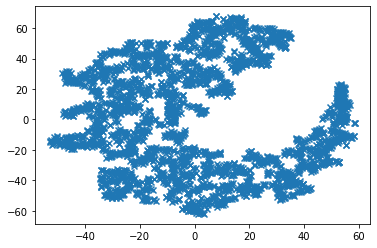

In [28]:
fig = plt.figure()
axes = fig.add_subplot(111)
cmap = plt.get_cmap('gnuplot')
columns = image_features.shape[1]
axes.scatter(x, y, marker='x')
plt.show()

In [29]:
!jupyter nbconvert --to pdf lab2.ipynb

[NbConvertApp] Converting notebook lab2.ipynb to pdf
[NbConvertApp] Support files will be in lab2_files/
[NbConvertApp] Making directory ./lab2_files
[NbConvertApp] Making directory ./lab2_files
[NbConvertApp] Writing 56308 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 111457 bytes to lab2.pdf
